In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Feedforward Neural Network

In [37]:
data = pd.read_csv('monthly-sunspots.csv')
data

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
...,...,...
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3


In [38]:
data.dtypes

Month        object
Sunspots    float64
dtype: object

In [39]:
data.isnull().sum()

Month       0
Sunspots    0
dtype: int64

In [40]:
data.isna().sum()

Month       0
Sunspots    0
dtype: int64

In [41]:
# Convert the 'month' column to datetime
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.dtypes

Month       datetime64[ns]
Sunspots           float64
dtype: object

### Split test and train data

In [42]:
# Calculate the split index (75% train, 25% test)
split_index = int(len(data) * 0.75)

# Split the data
train = data[:split_index]
test = data[split_index:]

In [43]:
# Normalize the data (important for neural networks)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Sunspots']])
test_scaled = scaler.transform(test[['Sunspots']])

In [44]:
# Function to create sequences (e.g., last 3 months to predict the next month)
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

# Create sequences
SEQ_LENGTH = 3
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)


In [45]:
def reverse_sequence(data, seq_length):
    new_y = [] 
    for arr in data: 
        new_y.append(arr[seq_length - 1][0])

    return np.array(new_y).reshape(-1, 1)

In [46]:
# Build the neural network model
model = Sequential([
    Dense(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=1, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


  18/2112 [..............................] - ETA: 6s - loss: 0.0177  

2024-08-19 22:28:22.788798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2106/2112 [============================>.] - ETA: 0s - loss: 0.0065

2024-08-19 22:28:29.894367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/22 [===========================>..] - ETA: 0s - loss: 0.0092

2024-08-19 22:28:31.392915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 6ms/step - loss: 0.0094
Test Loss: 0.009423866868019104
22/22 [==============================] - 0s 4ms/step


2024-08-19 22:28:31.665715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 5ms/step


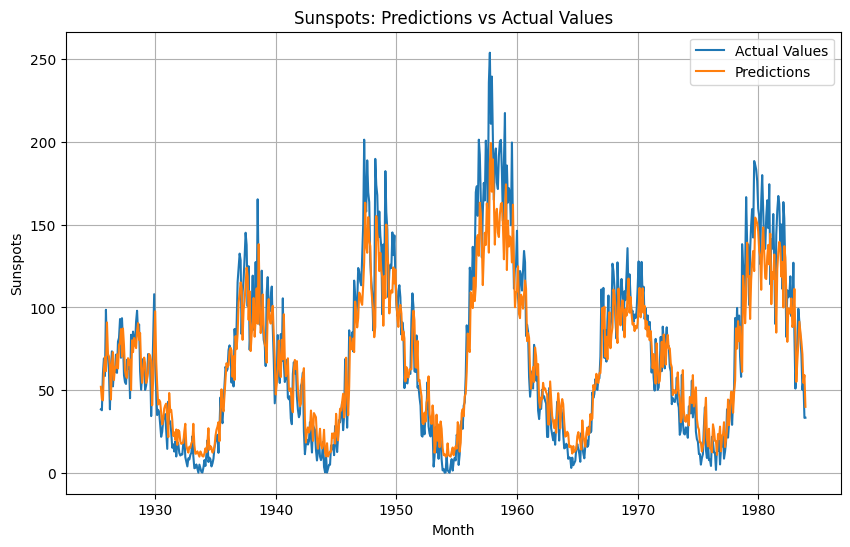

In [47]:

# Predicting values
predictions = model.predict(X_test)
predictions_trans = reverse_sequence(predictions, SEQ_LENGTH)


# # Inverse transform to get actual values
predictions_actual = scaler.inverse_transform(predictions_trans)
y_test_actual = scaler.inverse_transform(y_test)


# Align indices for plotting
test_start_index = split_index + SEQ_LENGTH
test_end_index = test_start_index + len(predictions)

# Slice the 'Month' column to match the length of predictions and y_test
months = data['Month'][test_start_index:test_end_index]

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(months, y_test_actual, label='Actual Values')
plt.plot(months, predictions_actual, label='Predictions')
plt.title('Sunspots: Predictions vs Actual Values')
plt.xlabel('Month')
plt.ylabel('Sunspots')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
mae = mean_absolute_error(y_test_actual, predictions_actual)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 15.182699841176005


# Recurrent Neural Network

In [49]:
# Use the same sequence creation function
SEQ_LENGTH = 3
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)

# Reshape data for RNN input (batch_size, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [50]:
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
 1/66 [..............................] - ETA: 27s - loss: 0.0731

2024-08-19 22:28:32.676364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 9ms/step - loss: 0.0111
Epoch 2/5
66/66 [==============================] - 1s 9ms/step - loss: 0.0042
Epoch 3/5
66/66 [==============================] - 1s 9ms/step - loss: 0.0041
Epoch 4/5
66/66 [==============================] - 1s 10ms/step - loss: 0.0041
Epoch 5/5
66/66 [==============================] - 1s 10ms/step - loss: 0.0042


In [52]:
predictions_rnn = model.predict(X_test)

# Reshape predictions if necessary
predictions_rnn = predictions_rnn.reshape(-1, 1)

22/22 [==============================] - 0s 5ms/step


2024-08-19 22:28:36.029244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [55]:
# Inverse transform predictions and actual values
predictions_actual_rnn = scaler.inverse_transform(predictions_rnn)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

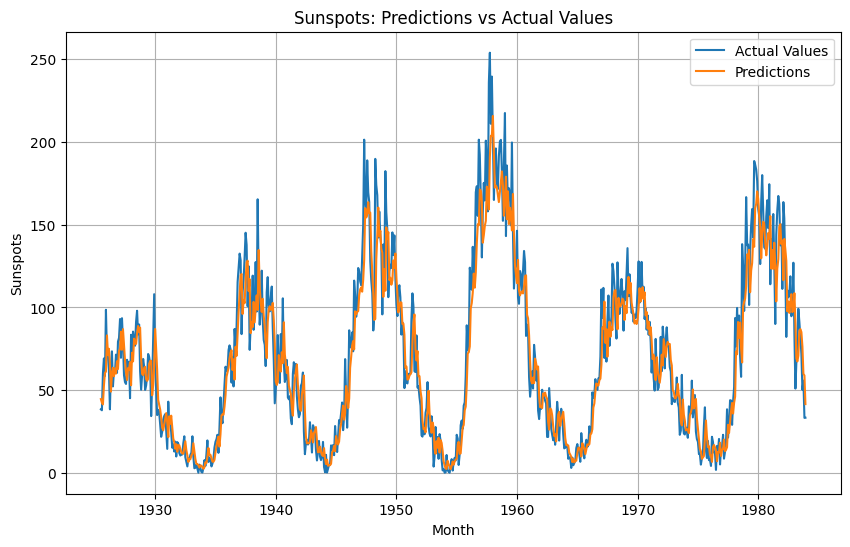

In [56]:
# Align indices for plotting
test_start_index = split_index + SEQ_LENGTH
test_end_index = test_start_index + len(predictions_rnn)

# Slice the 'Month' column to match the length of predictions and y_test
months = data['Month'][test_start_index:test_end_index]

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(months, y_test_actual, label='Actual Values')
plt.plot(months, predictions_actual_rnn, label='Predictions')
plt.title('Sunspots: Predictions vs Actual Values')
plt.xlabel('Month')
plt.ylabel('Sunspots')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Inverse transform predictions and actual values
predictions_actual_rnn = scaler.inverse_transform(predictions_rnn)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predictions_actual_rnn)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 13.177423370326009
